In [1]:
from collections import defaultdict
import math
import random

import gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable
import tqdm

sns.set_theme()

In [2]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device('cpu')

In [3]:
device

device(type='cuda', index=0)

### Реализация окружения

In [4]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

In [5]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None
        
        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
#             print((i,j))
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

In [6]:
def state_to_tensor(state):
    size = int(math.sqrt(len(state)))
    state_int = np.array([int(square) for square in state])
    noughts, empty, crosses = [np.where(state_int == s, 1, 0).reshape(size, size) for s in range(3)]
    return torch.Tensor(np.stack([crosses, noughts, empty])).reshape(3, size, size)

In [7]:
def plot_board(env, pi, showtext=True, verbose=True, fontq=20, fontx=60):
    '''Рисуем доску с оценками из стратегии pi'''
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s, actions = env.getHash(), env.getEmptySpaces()
    if pi is not None and s in pi.Q:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi.Q[s][i]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 10), vmin=-1, vmax=1)
    if showtext:
        for i,a in enumerate(actions):
            if pi is not None and s in pi.Q:
                ax.text( a[1] , a[0] , "%.3f" % pi.Q[s][i], fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
#             else:
#                 ax.text( a[1] , a[0] , "???", fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
    cbar = plt.colorbar(surf, ticks=[0, 1])
    ax.grid(False)
    plt.show()

def get_and_print_move(env, pi, s, actions, random=False, verbose=True, fontq=20, fontx=60):
    '''Делаем ход, рисуем доску'''
    plot_board(env, pi, fontq=fontq, fontx=fontx)
    if verbose and (pi is not None):
        if s in pi.Q:
            for i,a in enumerate(actions):
                print(i, a, pi.Q[s][i])
        else:
            print("Стратегия не знает, что делать...")
    if random:
        return np.random.randint(len(actions))
    else:
        return pi.getActionGreedy(s, len(actions))

In [8]:
def plot_test_game(env, pi1, pi2, random_crosses=False, random_naughts=True, verbose=True, fontq=20, fontx=60):
    '''Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры'''
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = get_and_print_move(env, pi1, s, actions, random=random_crosses, verbose=verbose, fontq=fontq, fontx=fontx)
        else:
            a = get_and_print_move(env, pi2, s, actions, random=random_naughts, verbose=verbose, fontq=fontq, fontx=fontx)
        observation, reward, done, info = env.step(actions[a])
        if reward == 1:
            print("Крестики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
        if reward == -1:
            print("Нолики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)

### Часть первая: крестики-нолики при помощи Q-обучения

##### 1. Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.

In [ ]:
def eps_greedy_pi(state, actions, Q, eps):
    if np.random.rand() > eps:
        return actions[np.argmax(Q[state][tuple(actions.T)])]
    else:
        return actions[np.random.randint(0, len(actions))]

In [ ]:
def Q_learning_episode(env, Q, alpha=0.05, eps=0.0, gamma=1.0):
    env.reset()
    state_crosses, actions_crosses = env.getHash(), env.getEmptySpaces()
    a_crosses = eps_greedy_pi(state_crosses, actions_crosses, Q, eps)
    observation, reward, done, info = env.step(a_crosses)
    state_noughts, actions_noughts, _ = observation
    a_noughts = eps_greedy_pi(state_noughts, actions_noughts, Q, eps)
    done = False
    while not done:
        if env.curTurn == 1:
            observation, reward, done, info = env.step(a_crosses)
            if reward == 1:
                Q[state_crosses][tuple(a_crosses)] = reward
            next_state_noughts, actions_noughts, _ = observation
            if actions_noughts.size > 0:
                next_a_noughts = eps_greedy_pi(next_state_noughts, actions_noughts, Q, eps)
            Q[state_noughts][tuple(a_noughts)] += alpha * (-reward + gamma*np.max(Q[next_state_noughts]) 
                                                           - Q[state_noughts][tuple(a_noughts)])
            state_noughts, a_noughts = next_state_noughts, next_a_noughts
        else:
            observation, reward, done, info = env.step(a_noughts)
            if reward == -1:
                Q[state_noughts][tuple(a_noughts)] = reward * -1
            next_state_crosses, actions_crosses, _ = observation
            if actions_crosses.size > 0:
                next_a_crosses = eps_greedy_pi(next_state_crosses, actions_crosses, Q, eps)
            Q[state_crosses][tuple(a_crosses)] += alpha * (reward + gamma*np.max(Q[next_state_crosses]) 
                                                           - Q[state_crosses][tuple(a_crosses)])
            state_crosses, a_crosses = next_state_crosses, next_a_crosses

In [ ]:
def Q_learning(env, gamma, n_of_episodes, eps, alpha, estim_epsds=10000, estim_step=5000):
    Q = defaultdict(lambda: np.zeros((N_ROWS, N_COLS)))
    avg_crosses_rewards, avg_noughts_rewards = [], []
    episodes = []
    for episode in range(n_of_episodes):
        Q_learning_episode(env, Q, alpha, eps, gamma)
        if (episode+1) % estim_step == 0:
            crosses_rewards = np.array([eval_strategy_vs_random(env, Q, "X") for episode in range(estim_epsds)])
            noughts_rewards = np.array([eval_strategy_vs_random(env, Q, "O") for episode in range(estim_epsds)])
            avg_crosses_rewards.append(crosses_rewards.mean())
            avg_noughts_rewards.append(noughts_rewards.mean())
            episodes.append(episode)
    return Q, avg_crosses_rewards, avg_noughts_rewards, episodes

In [ ]:
def eval_strategy_vs_random(env, Q, player):
    players = {"X": 1, "O": -1}
    env.reset()
    done = False
    while not done:
        state, actions = env.getHash(), env.getEmptySpaces()
        action = actions[Q[state][tuple(actions.T)].argmax()] if env.curTurn == players[player] else actions[np.random.randint(0, len(actions))]
        observation, reward, done, info = env.step(action)
    return reward * players[player]

In [ ]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

In [ ]:
env = TicTacToe(N_ROWS, N_COLS, N_WIN)
n_of_episodes = 200000
gamma = 1
eps = 0.3
alpha = 0.05
estim_epsds = 10000
estim_step = 5000

Q, crosses_rewards, noughts_rewards, episodes = Q_learning(env, gamma, n_of_episodes, eps, alpha, 
                                                           estim_epsds=estim_epsds, estim_step=estim_step)

env.close()

График обучения стратегии в играх против случайной стратегии:

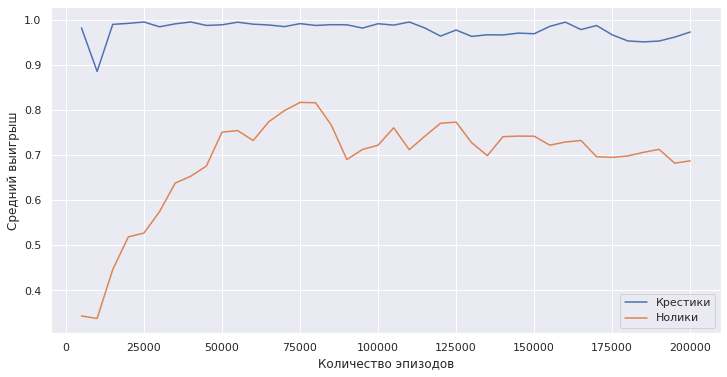

In [ ]:
plt.figure(figsize=(12, 6))
plt.xlabel('Количество эпизодов')
plt.ylabel('Средний выигрыш')
plt.plot(episodes, crosses_rewards, label='Крестики')
plt.plot(episodes, noughts_rewards, label='Нолики')
plt.legend()
plt.show()

##### 2. Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.

Обучим стратегию для игры на поле 4x4:

In [ ]:
N_ROWS, N_COLS, N_WIN = 4, 4, 4

In [ ]:
env = TicTacToe(N_ROWS, N_COLS, N_WIN)
n_of_episodes = 200000
gamma = 1
eps = 0.4
alpha = 0.03
estim_epsds = 10000
estim_step = 5000

Q, crosses_rewards, noughts_rewards, episodes = Q_learning(env, gamma, n_of_episodes, eps, alpha, 
                                                           estim_epsds=estim_epsds, estim_step=estim_step)

env.close()

График обучения стратегии в играх против случайной стратегии:

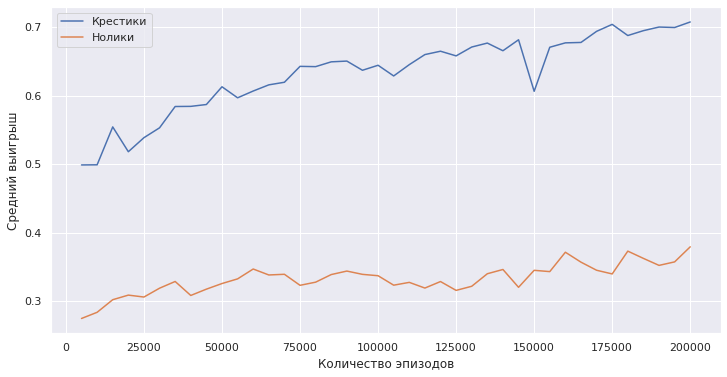

In [ ]:
plt.figure(figsize=(12, 6))
plt.xlabel('Количество эпизодов')
plt.ylabel('Средний выигрыш')
plt.plot(episodes, crosses_rewards, label='Крестики')
plt.plot(episodes, noughts_rewards, label='Нолики')
plt.legend()
plt.show()

Видим, что на поле размером 4x4 обучение идет, но еще не закончилось - нужно побольше времени.

### Часть вторая: добавим нейронных сетей

##### 3. Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов.

In [9]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def store(self, exptuple):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = exptuple
        self.position = (self.position + 1) % self.capacity
       
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [10]:
class TicTacToeDQN():
    def __init__(self, n_rows, n_cols, n_win, model_ctor, gamma=1.0, batch_size=512, device=device):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.env = TicTacToe(n_rows, n_cols, n_win)
        self.device = device
        self.model = [model_ctor().to(device), model_ctor().to(device)]
        self.memory = [ReplayMemory(100000), ReplayMemory(100000)]
        self.optimizer = [optim.Adam(self.model[0].parameters(), 0.001, weight_decay=0.001),
                          optim.Adam(self.model[1].parameters(), 0.001, weight_decay=0.001)]
        self.steps_done = 0
        self.prev_states = [None] * 2
        self.prev_actions = {}
        
        self.gamma = gamma
        self.batch_size = batch_size
        
        self.eps_init, self.eps_final, self.eps_decay = 0.9, 0.05, 200
        self.num_step = 0

    def select_greedy_action(self, state, player):
        return self.model[player](state.unsqueeze(0)).data.max(1)[1].view(1, 1)

    def select_action(self, state, player):
        sample = random.random()
        self.num_step += 1
        eps_threshold = self.eps_final + (self.eps_init - self.eps_final) * math.exp(-1. * self.num_step / self.eps_decay)
        if sample > eps_threshold:
            return self.select_greedy_action(state, player)
        else:
            return torch.tensor([[random.randrange(self.n_rows * self.n_cols)]], dtype=torch.int64)
        
    def run_episode(self, do_learning=True, greedy=False):
        self.env.reset()
        state, empty, turn = self.env.getState()
        player = 0 if turn == 1 else 1
        self.prev_states = [None] * 2
        self.prev_actions = {}
        while True:
            state_tensor = state_to_tensor(state)
            self.prev_states[player] = state_tensor
            with torch.no_grad():
                if greedy:
                    action_i = self.select_greedy_action(state_tensor.to(self.device), player).cpu()
                else:
                    action_i = self.select_action(state_tensor.to(self.device), player).cpu()
            self.prev_actions[player] = action_i
            action = self.env.action_from_int(action_i.numpy()[0][0])
            (next_state, empty, turn), reward, done, _ = self.env.step(action)
            player = 0 if turn == 1 else 1
            next_state_tensor = state_to_tensor(next_state)

            if reward == -10:
                transition = (state_tensor, action_i, next_state_tensor, torch.tensor([reward], dtype=torch.float32))
                self.memory[player].store(transition)
            else:
                if self.prev_states[player] is not None:
                    if reward == -turn:
                        transition = (self.prev_states[not player], self.prev_actions[not player], 
                                      next_state_tensor, torch.tensor([1.0], dtype=torch.float32))
                        self.memory[not player].store(transition)
                    transition = (self.prev_states[player], self.prev_actions[player], next_state_tensor, 
                                  torch.tensor([reward * turn], dtype=torch.float32))
                    self.memory[player].store(transition)

            if do_learning:
                self.learn(player)

            state = next_state

            if done:
                break

    def learn(self, player):
        if min([len(self.memory[0]), len(self.memory[1])]) < self.batch_size:
            return

        # берём мини-батч из памяти
        transitions = self.memory[player].sample(self.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)

        batch_state = Variable(torch.stack(batch_state).to(self.device))
        batch_action = Variable(torch.cat(batch_action).to(self.device))
        batch_reward = Variable(torch.cat(batch_reward).to(self.device))
        batch_next_state = Variable(torch.stack(batch_next_state).to(self.device))

        # считаем значения функции Q
        Q = self.model[player](batch_state).gather(1, batch_action).reshape([self.batch_size])

        # оцениваем ожидаемые значения после этого действия
        Qmax = self.model[player](batch_next_state).detach().max(1)[0]
        Qnext = batch_reward + (self.gamma * Qmax)

        # и хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
        loss = F.smooth_l1_loss(Q, Qnext)

        self.optimizer[player].zero_grad()
        loss.backward()
        self.optimizer[player].step()

    def eval_strategy_vs_random(self, player, estim_epsds):
        rewards = []
        for episode in range(estim_epsds):
            self.env.reset()
            state, empty, turn = self.env.getState()
            done = False
            while not done:
                if turn == player:
                    state_tensor = state_to_tensor(state)
                    action_i = self.select_greedy_action(state_tensor.to(device), 0 if player == 1 else 1)
                    action = self.env.action_from_int(action_i)
                else:
                    action_i = np.random.randint(empty.shape[0])
                    action = empty[action_i]
                (state, empty, turn), reward, done, _ = self.env.step(action)
            if reward != -10:
                rewards.append(reward * player)
            else:
                if turn == player:
                    rewards.append(reward)
        return np.array(rewards)

In [11]:
def DQN_learning(model, n_of_episodes, estim_epsds, estim_step):
    crosses_win_pct, noughts_win_pct = [], []
    for episode in tqdm.tqdm(range(n_of_episodes)):
        model.run_episode(do_learning=True)
        if (episode+1) % estim_step == 0:
            crosses_rewards = model.eval_strategy_vs_random(1, estim_epsds)
            noughts_rewards = model.eval_strategy_vs_random(-1, estim_epsds)
            crosses_win_pct.append(np.sum(crosses_rewards == 1) / estim_epsds)
            noughts_win_pct.append(np.sum(noughts_rewards == 1) / estim_epsds)
    return crosses_win_pct, noughts_win_pct

Обучим модель для игры на поле размером 3x3

In [12]:
class Network_3x3(nn.Module):
    def __init__(self, hid_size=128):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=3, out_channels=hid_size * 2, kernel_size=3)
        self.l1 = nn.Linear(hid_size * 2, hid_size)
        self.l2 = nn.Linear(hid_size, 3 * 3)

    def forward(self, x):
        x = F.relu(self.conv(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x

In [ ]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3
gamma = 0.9
dqn_3x3 = TicTacToeDQN(N_ROWS, N_COLS, N_WIN, Network_3x3, gamma)
n_of_episodes = 25000
estim_epsds = 1000
estim_step = 1000

crosses_win_pct_3x3, noughts_win_pct_3x3 = DQN_learning(dqn_3x3, n_of_episodes, estim_epsds, estim_step)

100%|██████████| 25000/25000 [18:11<00:00, 22.90it/s]


График обучения модели в играх против случайной стратегии:

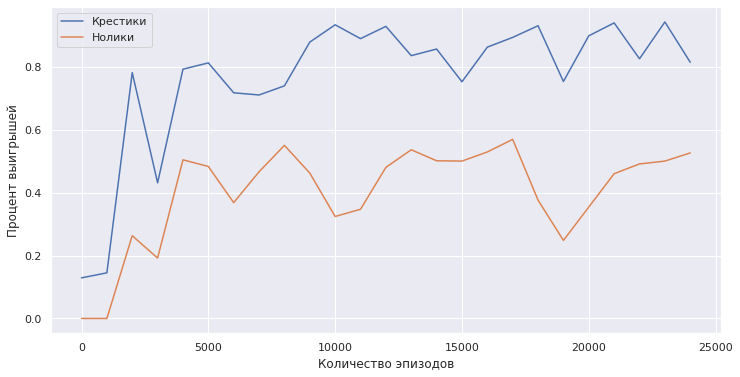

In [ ]:
plt.figure(figsize=(12, 6))
plt.xlabel('Количество эпизодов')
plt.ylabel('Процент выигрышей')
plt.plot(range(0, n_of_episodes, estim_step), crosses_win_pct_3x3, label='Крестики')
plt.plot(range(0, n_of_episodes, estim_step), noughts_win_pct_3x3, label='Нолики')
plt.legend()
plt.show()

По-хорошему, нужно бы обучать дальше.

Обучим модель для игры на поле размером 4x4

In [13]:
class Network_4x4(nn.Module):
    def __init__(self, hid_size1=16, hid_size2=128):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=hid_size1, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=hid_size1, out_channels=hid_size2 * 2, kernel_size=2)
        self.l1 = nn.Linear(hid_size2 * 2, hid_size2)
        self.l2 = nn.Linear(hid_size2, 4 * 4)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x

In [ ]:
N_ROWS, N_COLS, N_WIN = 4, 4, 4
gamma = 0.8
dqn_4x4 = TicTacToeDQN(N_ROWS, N_COLS, N_WIN, Network_4x4, gamma)
n_of_episodes = 25000
estim_epsds = 1000
estim_step = 1000

crosses_win_pct_4x4, noughts_win_pct_4x4 = DQN_learning(dqn_4x4, n_of_episodes, estim_epsds, estim_step)

100%|██████████| 25000/25000 [33:03<00:00, 12.60it/s]


График обучения модели в играх против случайной стратегии:

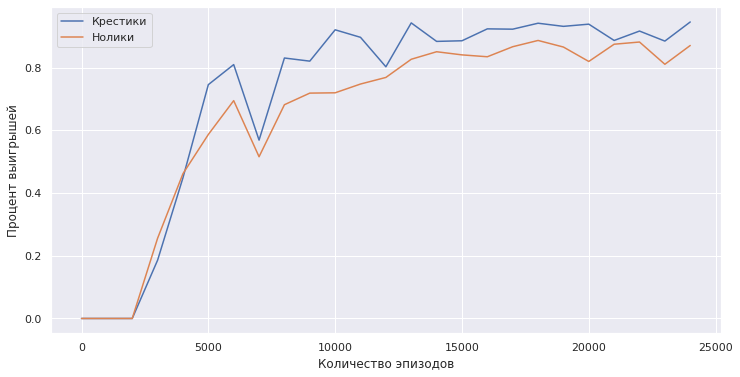

In [ ]:
plt.figure(figsize=(12, 6))
plt.xlabel('Количество эпизодов')
plt.ylabel('Процент выигрышей')
plt.plot(range(0, n_of_episodes, estim_step), crosses_win_pct_4x4, label='Крестики')
plt.plot(range(0, n_of_episodes, estim_step), noughts_win_pct_4x4, label='Нолики')
plt.legend()
plt.show()

Видим, что по сравнению с табличным Q-learning обучение происходит намного быстрее.

##### 4. Реализуйте Double DQN и/или Dueling DQN.

**Реализуем Double DQN**

In [14]:
class TicTacToeDoubleDQN(TicTacToeDQN):
    def __init__(self, n_rows, n_cols, n_win, model_ctor, gamma=1.0, batch_size=512, device=device, period=500):
        super(TicTacToeDoubleDQN, self).__init__(n_rows, n_cols, n_win, model_ctor, gamma, batch_size, device)
        self.target_model = [model_ctor().to(device), model_ctor().to(device)]
        self.epsds_learned = [0, 0]
        self.period = period

    def learn(self, player):
        if min([len(self.memory[0]), len(self.memory[1])]) < self.batch_size:
            return

        # берём мини-батч из памяти
        transitions = self.memory[player].sample(self.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)

        batch_state = Variable(torch.stack(batch_state).to(self.device))
        batch_action = Variable(torch.cat(batch_action).to(self.device))
        batch_reward = Variable(torch.cat(batch_reward).to(self.device))
        batch_next_state = Variable(torch.stack(batch_next_state).to(self.device))

        # считаем значения функции Q
        Q = self.model[player](batch_state).gather(1, batch_action).reshape([self.batch_size])

        # оцениваем ожидаемые значения после этого действия
        Qmax = self.target_model[player](batch_next_state).detach().max(1)[0]
        Qnext = batch_reward + (self.gamma * Qmax)

        # и хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
        loss = F.smooth_l1_loss(Q, Qnext)

        self.optimizer[player].zero_grad()
        loss.backward()
        self.optimizer[player].step()
        
        self.epsds_learned[player] += 1
        if self.epsds_learned[player] % self.period == 0:
            self.target_model[player].load_state_dict(self.model[player].state_dict())

Обучим модель для игры на поле размером 3x3

In [15]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3
gamma = 0.7
double_dqn_3x3 = TicTacToeDoubleDQN(N_ROWS, N_COLS, N_WIN, Network_3x3, gamma)
n_of_episodes = 20000
estim_epsds = 1000
estim_step = 1000

crosses_win_pct_3x3_dbl, noughts_win_pct_3x3_dbl = DQN_learning(double_dqn_3x3, n_of_episodes, estim_epsds, estim_step)

100%|██████████| 20000/20000 [14:47<00:00, 22.54it/s]


График обучения модели в играх против случайной стратегии:

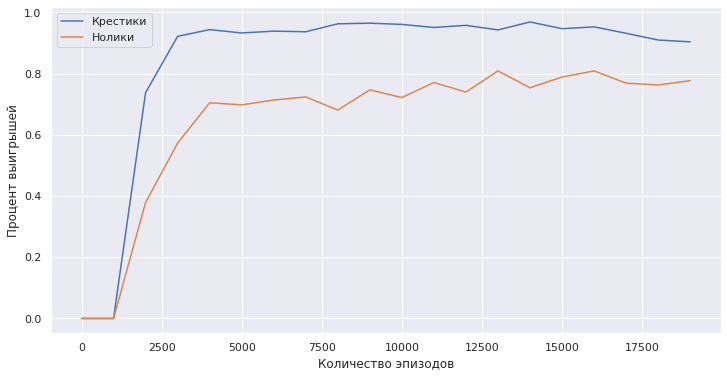

In [16]:
plt.figure(figsize=(12, 6))
plt.xlabel('Количество эпизодов')
plt.ylabel('Процент выигрышей')
plt.plot(range(0, n_of_episodes, estim_step), crosses_win_pct_3x3_dbl, label='Крестики')
plt.plot(range(0, n_of_episodes, estim_step), noughts_win_pct_3x3_dbl, label='Нолики')
plt.legend()
plt.show()

Довольно хорошо видно улучшение качества модели по сравнению с обычной DQN.

Обучим модель для игры на поле размером 4x4

In [17]:
N_ROWS, N_COLS, N_WIN = 4, 4, 4
gamma = 0.7
double_dqn_4x4 = TicTacToeDoubleDQN(N_ROWS, N_COLS, N_WIN, Network_4x4, gamma)
n_of_episodes = 25000
estim_epsds = 1000
estim_step = 1000

crosses_win_pct_4x4_dbl, noughts_win_pct_4x4_dbl = DQN_learning(double_dqn_4x4, n_of_episodes, estim_epsds, estim_step)

100%|██████████| 25000/25000 [37:04<00:00, 11.24it/s]


График обучения модели в играх против случайной стратегии:

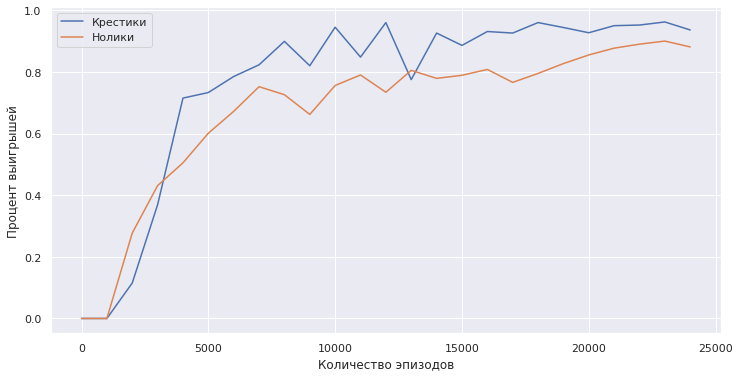

In [18]:
plt.figure(figsize=(12, 6))
plt.xlabel('Количество эпизодов')
plt.ylabel('Процент выигрышей')
plt.plot(range(0, n_of_episodes, estim_step), crosses_win_pct_4x4_dbl, label='Крестики')
plt.plot(range(0, n_of_episodes, estim_step), noughts_win_pct_4x4_dbl, label='Нолики')
plt.legend()
plt.show()

**Реализуем Dueling DQN**

Обучим модель для игры на поле размером 3x3

In [19]:
class DuelingNetwork_3x3(nn.Module):
    def __init__(self, hid_size=128):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=3, out_channels=hid_size * 2, kernel_size=3)
        self.lin = nn.Linear(hid_size * 2, hid_size)
        self.val = nn.Linear(hid_size, 1)
        self.adv = nn.Linear(hid_size, 3 * 3)

    def forward(self, x):
        x = F.relu(self.conv(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.lin(x))
        val_f = self.val(x)
        adv_f = self.adv(x)
        x = val_f + (adv_f - adv_f.mean(1, keepdim=True))
        return x

In [20]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3
gamma = 0.7
duel_dqn_3x3 = TicTacToeDQN(N_ROWS, N_COLS, N_WIN, DuelingNetwork_3x3, gamma)
n_of_episodes = 25000
estim_epsds = 1000
estim_step = 1000

crosses_win_pct_3x3_duel, noughts_win_pct_3x3_duel = DQN_learning(duel_dqn_3x3, n_of_episodes, estim_epsds, estim_step)

100%|██████████| 25000/25000 [24:01<00:00, 17.34it/s]


График обучения модели в играх против случайной стратегии:

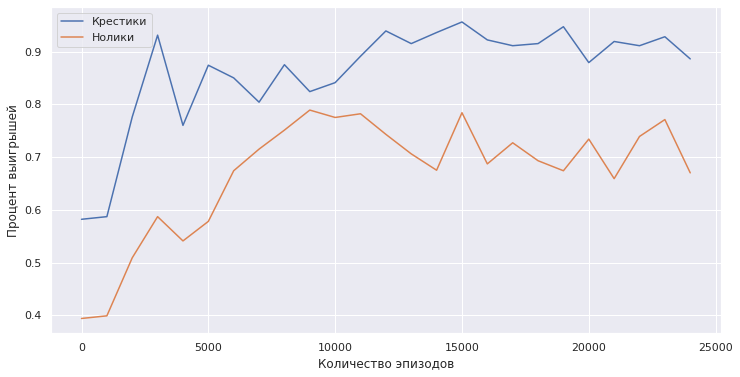

In [21]:
plt.figure(figsize=(12, 6))
plt.xlabel('Количество эпизодов')
plt.ylabel('Процент выигрышей')
plt.plot(range(0, n_of_episodes, estim_step), crosses_win_pct_3x3_duel, label='Крестики')
plt.plot(range(0, n_of_episodes, estim_step), noughts_win_pct_3x3_duel, label='Нолики')
plt.legend()
plt.show()

Видно, что по сравнению с обычной DQN качество стало получше.

Обучим модель для игры на поле размером 4x4

In [22]:
class DuelingNetwork_4x4(nn.Module):
    def __init__(self, hid_size1=16, hid_size2=128):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=hid_size1, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=hid_size1, out_channels=hid_size2 * 2, kernel_size=2)
        self.lin = nn.Linear(hid_size2 * 2, hid_size2)
        self.val = nn.Linear(hid_size2, 1)
        self.adv = nn.Linear(hid_size2, 4 * 4)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.lin(x))
        val_f = self.val(x)
        adv_f = self.adv(x)
        x = val_f + (adv_f - adv_f.mean(1, keepdim=True))
        return x

In [24]:
N_ROWS, N_COLS, N_WIN = 4, 4, 4
gamma = 0.7
duel_dqn_4x4 = TicTacToeDQN(N_ROWS, N_COLS, N_WIN, DuelingNetwork_4x4, gamma)
n_of_episodes = 30000
estim_epsds = 1000
estim_step = 1000

crosses_win_pct_4x4_duel, noughts_win_pct_4x4_duel = DQN_learning(duel_dqn_4x4, n_of_episodes, estim_epsds, estim_step)

100%|██████████| 30000/30000 [47:10<00:00, 10.60it/s]


График обучения модели в играх против случайной стратегии:

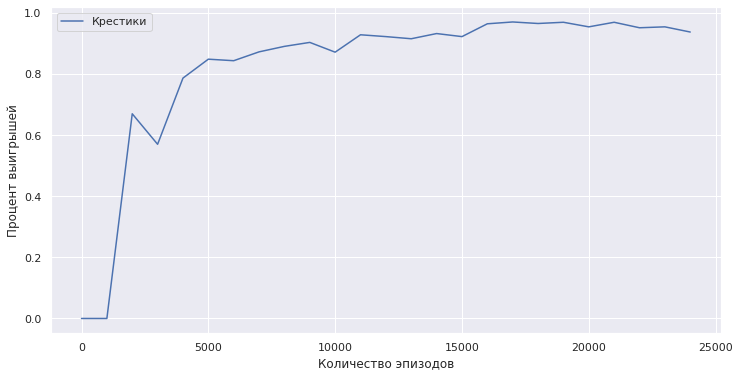

In [33]:
plt.figure(figsize=(12, 6))
plt.xlabel('Количество эпизодов')
plt.ylabel('Процент выигрышей')
plt.plot(range(0, n_of_episodes, estim_step), crosses_win_pct_4x4_duel, label='Крестики')
plt.legend()
plt.show()